In [6]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

from sccoda.model.scCODA_model import EricaModel

### Loading Data

In [ ]:
# Read data into pandas from csv

cell_counts = scd.haber()

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

: 

: 

### Converting data to anndata object

In [ ]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


: 

: 

In [ ]:

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)


       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


: 

: 

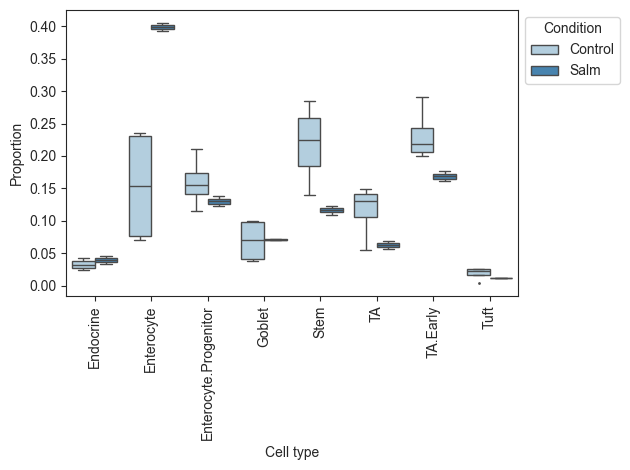

: 

: 

In [ ]:
viz.boxplots(data_salm, feature_name="Condition")
plt.show()

### Building Design Matrix for Covariate

In [ ]:
import patsy as pt

covariate_matrix_full = pt.dmatrix("Condition", data_salm.obs)
covariate_matrix=covariate_matrix_full[:,1:]
covariate_names = ["Condition"]  

: 

: 

In [ ]:
import numpy as np

cell_types = list(data_salm.var.index)
ref_idx = cell_types.index("Goblet")

model_salm = EricaModel(
    reference_cell_type=ref_idx,
    data_matrix=data_salm.X.astype("float64"),
    covariate_matrix=np.array(covariate_matrix),
    cell_types=cell_types,
    covariate_names=covariate_names,
    formula="Condition"
)


: 

: 

We first run the default parameters as a baseline.

In [ ]:
# Run HMC sampling
sim_results = model_salm.sample_hmc(
    num_results=5000,  
    num_burnin=1000,
    step_size=0.01,
    num_leapfrog_steps=10
)

# Summary
print(sim_results.summary())


100%|██████████| 5000/5000 [00:08<00:00, 573.99it/s]


MCMC sampling finished. (12.308 sec)
Acceptance rate: 43.4%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.106        33.520340
Enterocyte                       2.340       115.140420
Enterocyte.Progenitor            2.514       137.023497
Goblet                           1.731        62.624240
Stem                             2.741       171.941177
TA                               2.145        94.741528
TA.Early                         2.902       201.976716
Tuft                             0.486        18.032081


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        23.545922   
          Enterocyte                     1.40415

: 

: 

We now run EricaModel 6 different times, changing one default parameter for each run. First, we begin by changing the mean of the alpha random variable (the intercept for the GLM) to 1.0. We then change the standard deviation of the alpha random variable to 2.0. We then change the sigma parameter (which controls the magnitude of the raw effect) to 0.5. We also alter the gamma random variable (drawn from Normal distribution which controls sign and magnitude of the raw effect). First, we change the mean from 0.0 to 0 and then the standard deviation from 1.0 to 0.5. Finaly, we change the log-odds scale from 50.0 to 25. 

In [ ]:
default_priors = {
    "alpha_loc": 0.0,
    "alpha_sd": 5.0,
    "sigma_hc_scale": 1.0,
    "gamma_loc": 0.0,
    "gamma_sd": 1.0,
    "tau_temperature": 50.0
}

# Each dict changes only one prior from the default
priors_list = [
    {**default_priors, "alpha_loc": 0.5},
    {**default_priors, "alpha_loc": 10.0},          
    {**default_priors, "alpha_sd": 0.5},
    {**default_priors, "alpha_sd": 10.0},            
    {**default_priors, "sigma_hc_scale": 0.25},   
    {**default_priors, "sigma_hc_scale": 5.0},   
    {**default_priors, "gamma_loc": 0.25}, 
    {**default_priors, "gamma_loc": 5.0},          
    {**default_priors, "gamma_sd": 0.25},
    {**default_priors, "gamma_sd": 5.0},             
    {**default_priors, "tau_temperature": 1.0},
    {**default_priors, "tau_temperature": 100.0}
]

results = []

for i, priors in enumerate(priors_list, 1):
    print(f"\n=== Running model with prior {i}/{len(priors_list)} ===\n")
    
    cell_types = list(data_salm.var.index)
    ref_idx = cell_types.index("Goblet")

    model = EricaModel(
        reference_cell_type=ref_idx,
        data_matrix=data_salm.X.astype("float64"),
        covariate_matrix=covariate_matrix,
        cell_types=cell_types,
        covariate_names=covariate_names,
        formula="Condition",
        **priors  
    )
    
    # Run HMC sampling
    sample_result = model.sample_hmc(num_results=5000, num_burnin=1000)
    results.append(sample_result)
    
    # Print summary of the last run
    print(sample_result.summary())



=== Running model with prior 1/12 ===



100%|██████████| 5000/5000 [00:08<00:00, 601.30it/s]


MCMC sampling finished. (11.772 sec)
Acceptance rate: 52.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.116        34.445121
Enterocyte                       2.337       116.788820
Enterocyte.Progenitor            2.518       139.961495
Goblet                           1.748        64.804001
Stem                             2.711       169.756889
TA                               2.117        93.725224
TA.Early                         2.864       197.821943
Tuft                             0.450        17.696508


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.768124   
          Enterocyte                    1.333262

100%|██████████| 5000/5000 [00:08<00:00, 591.67it/s]


MCMC sampling finished. (11.886 sec)
Acceptance rate: 60.0%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        9.659        11.524882
Enterocyte                      13.485       528.746080
Enterocyte.Progenitor            7.896         1.976857
Goblet                           5.441         0.169739
Stem                            10.152        18.868773
TA                              11.932       111.889113
TA.Early                        -0.023         0.000719
Tuft                            12.301       161.823837


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                   -11.149203         0.000095   
          Enterocyte                    0.000000

100%|██████████| 5000/5000 [00:08<00:00, 597.43it/s]


MCMC sampling finished. (11.734 sec)
Acceptance rate: 54.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                       -0.108        57.274368
Enterocyte                       0.683       126.324399
Enterocyte.Progenitor            0.660       123.452096
Goblet                           0.206        78.402295
Stem                             0.834       146.914854
TA                               0.382        93.489880
TA.Early                         0.955       165.811764
Tuft                            -0.387        43.330345


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                          0.0        57.274368   
          Enterocyte                         0.0

100%|██████████| 5000/5000 [00:08<00:00, 595.19it/s]


MCMC sampling finished. (11.814 sec)
Acceptance rate: 44.4%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.183        35.441028
Enterocyte                       2.377       116.964462
Enterocyte.Progenitor            2.593       145.164872
Goblet                           1.810        66.345116
Stem                             2.732       166.812453
TA                               2.143        92.561209
TA.Early                         2.885       194.390718
Tuft                             0.467        17.320143


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.331887   
          Enterocyte                    1.347791

100%|██████████| 5000/5000 [00:08<00:00, 595.91it/s]


MCMC sampling finished. (12.056 sec)
Acceptance rate: 53.6%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.114        34.739640
Enterocyte                       2.347       119.209376
Enterocyte.Progenitor            2.499       138.778815
Goblet                           1.727        64.128021
Stem                             2.690       167.986129
TA                               2.119        94.905476
TA.Early                         2.855       198.121684
Tuft                             0.407        17.130858


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.315734   
          Enterocyte                    1.283002

100%|██████████| 5000/5000 [00:08<00:00, 593.48it/s]


MCMC sampling finished. (11.796 sec)
Acceptance rate: 49.7%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.103        35.516866
Enterocyte                       2.273       114.435081
Enterocyte.Progenitor            2.485       141.458683
Goblet                           1.712        65.301022
Stem                             2.664       169.187520
TA                               2.068        93.224232
TA.Early                         2.823       198.344949
Tuft                             0.397        17.531648


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.079523   
          Enterocyte                    1.395421

100%|██████████| 5000/5000 [00:08<00:00, 581.25it/s]


MCMC sampling finished. (12.062 sec)
Acceptance rate: 53.7%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.064        34.041186
Enterocyte                       2.296       116.695870
Enterocyte.Progenitor            2.481       140.410623
Goblet                           1.719        65.534135
Stem                             2.662       168.270222
TA                               2.074        93.463516
TA.Early                         2.831       199.252159
Tuft                             0.389        17.332289


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.175401   
          Enterocyte                    1.366102

100%|██████████| 5000/5000 [00:08<00:00, 563.28it/s]


MCMC sampling finished. (12.299 sec)
Acceptance rate: 76.3%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.999        33.656981
Enterocyte                       2.231       115.378785
Enterocyte.Progenitor            2.429       140.642400
Goblet                           1.670        65.839535
Stem                             2.630       171.952883
TA                               1.967        88.607854
TA.Early                         2.771       197.990787
Tuft                             0.524        20.930774


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        23.497283   
          Enterocyte                    1.418067

100%|██████████| 5000/5000 [00:09<00:00, 553.72it/s]


MCMC sampling finished. (12.634 sec)
Acceptance rate: 49.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.110        35.232102
Enterocyte                       2.343       120.899263
Enterocyte.Progenitor            2.476       138.097183
Goblet                           1.710        64.197076
Stem                             2.675       168.503693
TA                               2.088        93.686834
TA.Early                         2.832       197.148582
Tuft                             0.395        17.235267


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.868075   
          Enterocyte                    1.252798

100%|██████████| 5000/5000 [00:08<00:00, 556.22it/s]


MCMC sampling finished. (12.483 sec)
Acceptance rate: 96.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.218        37.209742
Enterocyte                       2.341       114.385075
Enterocyte.Progenitor            2.555       141.679946
Goblet                           1.774        64.882024
Stem                             2.707       164.938159
TA                               2.162        95.638036
TA.Early                         2.893       198.655191
Tuft                             0.470        17.611826


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        26.427106   
          Enterocyte                    1.380896

100%|██████████| 5000/5000 [00:08<00:00, 598.52it/s]


MCMC sampling finished. (11.734 sec)
Acceptance rate: 69.3%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.063        32.984107
Enterocyte                       2.359       120.545325
Enterocyte.Progenitor            2.484       136.595749
Goblet                           1.715        63.308894
Stem                             2.720       172.954028
TA                               2.129        95.777312
TA.Early                         2.844       195.786705
Tuft                             0.403        17.047880


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.193318        31.214941   
          Enterocyte                    1.225845

100%|██████████| 5000/5000 [00:08<00:00, 594.20it/s]


MCMC sampling finished. (11.834 sec)
Acceptance rate: 60.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.116        34.177601
Enterocyte                       2.339       116.113772
Enterocyte.Progenitor            2.533       140.973299
Goblet                           1.758        64.946932
Stem                             2.719       169.791379
TA                               2.131        94.308423
TA.Early                         2.869       197.269439
Tuft                             0.442        17.419156


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        24.358863   
          Enterocyte                     1.36064

: 

: 

In [ ]:
def values(arr):
        mean = arr.mean(axis=(0,1))               
        lo = np.percentile(arr, 2.5, axis=(0,1))  
        hi = np.percentile(arr, 97.5, axis=(0,1))  
        return mean, lo, hi

: 

In [ ]:
def summarize(data, prior_label, reference=0):
    "Extract summaries from inference data object"
    
    pred = data.posterior_predictive["prediction"].values
    cell_types = list(data.posterior_predictive.cell_type.values)
    reference_name = cell_types[reference]
    
    # Overall expected samples
    pred_mean, pred_lo, pred_hi = values(pred)
    
     # intercept expected sample
    alpha = data.posterior["alpha"].values  
    alpha_mean, alpha_lo, alpha_hi = values(alpha[..., np.newaxis])  
    
     # effect expected sample
    beta = data.posterior["beta"].values 
    beta_mean, beta_lo, beta_hi = values(beta[..., 0, :][..., np.newaxis])
    
    #log fold change
    ref_pred = pred[..., reference:reference+1] 
    logfc = np.log2(pred / ref_pred)
    logfc_mean, logfc_lo, logfc_hi = values(logfc)
    
    rows = []
    for i, ct in enumerate(cell_types):
        rows.append({
            "cell_type": ct,
            "reference": reference_name,
            "prior": prior_label,
            "metric": "expected_sample",
            "mean": pred_mean[:, i].mean(),
            "lo": pred_lo[:, i].mean(),
            "hi": pred_hi[:, i].mean()
        })
        rows.append({
            "cell_type": ct,
            "reference": reference_name,
            "prior": prior_label,
            "metric": "intercept_expected_sample",
            "mean": alpha_mean[:, i].mean(),
            "lo": alpha_lo[:, i].mean(),
            "hi": alpha_hi[:, i].mean()
        })
        rows.append({
            "cell_type": ct,
            "reference": reference_name,
            "prior": prior_label,
            "metric": "effect_expected_sample",
            "mean": beta_mean[:, i].mean(),
            "lo": beta_lo[:, i].mean(),
            "hi": beta_hi[:, i].mean()
        })
        rows.append({
            "cell_type": ct,
            "reference": reference_name,
            "prior": prior_label,
            "metric": "log2FC",
            "mean": logfc_mean[:, i].mean(),
            "lo": logfc_lo[:, i].mean(),
            "hi": logfc_hi[:, i].mean()
        })

    return pd.DataFrame(rows)

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid(df):
    metrics = ["expected_samples", "log2FC", "effect_expected_sample", "intercept_expected_sample"]
    n_metrics = len(metrics)
    cell_types = df["cell_type"].unique()
    n_cells = len(cell_types)

    fig, axes = plt.subplots(n_cells, n_metrics, figsize=(4*n_metrics, 3*n_cells), sharex="col")

    if n_cells == 1: 
        axes = axes[np.newaxis, :]

    for i, ct in enumerate(cell_types):
        for j, metric in enumerate(metrics):
            sub = df[(df["cell_type"] == ct) & (df["metric"] == metric)]

            if metric == "expected_sample":
                axes[i, j].bar(sub["prior"], sub["mean"])

            else:
                axes[i, j].errorbar(
                    sub["prior"], sub["mean"],
                    yerr=[sub["mean"]-sub["lo"], sub["hi"]-sub["mean"]],
                    fmt="-o"
                )

            if i == 0:
                axes[i, j].set_title(metric.replace("_", " ").title())
            if j == 0:
                axes[i, j].set_ylabel(ct)
            else:
                axes[i, j].set_ylabel("")

    plt.tight_layout()
    return fig, axes


: 

In [ ]:
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[0], prior_label="low", reference=ref_idx)
df_high = summarize(results[1], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)

plot_grid(df_all)
plt.show()

NameError: name 'sim_results' is not defined

: 